In [1]:
import pandas as pd

sun_df = pd.read_csv('hg38_features.txt', sep='\t')
sun_df.columns = ['loc', 'NAB', 'NC', 'ND', 'NN']
sun_df = (sun_df.set_index('loc') * 2).reset_index()
sun_df.head()

,loc,NAB,NC,ND,NN
0,56,0,0,0,2
1,178,0,0,2,0
2,240,0,0,0,2
3,386,4,0,0,0
4,393,2,0,0,0


In [2]:
from glob import glob
g = glob('/hive/users/ifiddes/simons_normals/96kb_consensus/*consensus.bam')

In [3]:
from tools.bio import *
fa = '/hive/users/ifiddes/notch2nl_berkeley_data/imputation_pipeline/copy_number/consensus.fa'
_, seq = read_fasta(fa, None).next()

In [4]:
def ref_count(s):
    return s[s.ref]


def load_pileup(pileup_path):
    r = [x.split() for x in open(pileup_path)]
    return pd.DataFrame(r[1:], columns=r[0])



def convert_pileup(pileup_recs, pileup_converter):
    with TemporaryFilePath() as tmp, TemporaryFilePath() as tmp2:
        with open(tmp, 'w') as outf:
            for l in pileup_recs:
                outf.write(l + '\n')
        cmd = ['perl', pileup_converter, tmp, 0, tmp2]
        r = run_proc(cmd, stderr='/dev/null', stdout='/dev/null')
        return load_pileup(tmp2)

    
def make_pileup(bam):
    """Construct a pileup from a bam"""
    cmd = ['samtools', 'mpileup', bam]
    return call_proc_lines(cmd)


bases = {'A', 'T', 'G', 'C'}
def alt_count(s):
    return sum(s[x] for x in bases if x != s.ref)


def parse_converted_pileup(df, seq):
    df['loc'] = np.array(map(int, df['loc'])) - 1
    df['ref'] = [seq[i] for i in df['loc']]
    df = df[df.ref.isin(bases)]
    df['A'] = pd.to_numeric(df['A']) + pd.to_numeric(df['a'])
    df['C'] = pd.to_numeric(df['C']) + pd.to_numeric(df['c'])
    df['G'] = pd.to_numeric(df['G']) + pd.to_numeric(df['g'])
    df['T'] = pd.to_numeric(df['T']) + pd.to_numeric(df['t'])
    df = df[['loc', 'ref', 'A', 'C', 'G', 'T']]
    df['coverage'] = df[['A', 'T', 'G', 'C']].sum(axis=1)
    df['ref_count'] = df.apply(ref_count, axis=1)
    df['alt_count'] = df.apply(alt_count, axis=1)
    df['ratio'] = 1.0 * df.alt_count / (df.alt_count + df.ref_count)
    return df


In [5]:
import numpy as np
from tools.procOps import *
from tools.fileOps import *
import multiprocessing
bases = {'A', 'T', 'G', 'C'}
pileup_converter = '/cluster/home/ifiddes/pileup2base/pileup2base.pl'
pd.set_option('chained_assignment',None)
def parse_fn(bam):
    n = os.path.basename(bam).split('.')[0]
    pileup_recs = make_pileup(bam)
    df = convert_pileup(pileup_recs, pileup_converter)
    df = parse_converted_pileup(df, seq)
    out = os.path.join('/hive/users/ifiddes/simons_normals/96kb_consensus/', n + '.parsed_pileup.txt')
    df.to_csv(out, sep='\t')
    return df


bams = glob('/hive/users/ifiddes/simons_normals/96kb_consensus/*.filtered.consensus.bam')
p = multiprocessing.Pool(processes=15)
r = p.map(parse_fn, bams)
dfs = {os.path.basename(bam).split('.')[0]: df for bam, df in zip(bams, r)}
p.close()
p.join()

In [6]:
files = glob('/hive/users/ifiddes/simons_normals/*.filtered.txt')

from collections import Counter
def convert(x):
    x = x.split(':')
    n, v = x
    v = int(v)
    return n, v

m = {}
for x in files:
    n = os.path.basename(x).split('.')[0]
    l = open(x).next().rstrip().split()
    c = []
    for x in l[2:4]:
        _, v = convert(x)
        c.append(v)
    m[n] = c

In [7]:
def calculate_deviance(s):
    if s.alt_count == 0 or s.coverage <= 20:
        return None
    deviance = (s.expected_alt - s.alt_count) / (np.sqrt(1.0 * s.coverage * s.ratio * (1 - s.ratio)))
    return deviance


def calculate_expected(s, tot):
    """Expected value"""
    expected_ratio = (1.0 * s.NAB + s.NC + s.ND + s.NN) / tot
    return expected_ratio * s.coverage

In [8]:
positions = set(sun_df['loc'])
dev_dfs = {}
for n, df in dfs.iteritems():
    if n not in m:
        continue
    num_c, num_d = m[n]
    tot = 6 + num_c + num_d
    df_m = df.merge(sun_df, on='loc')
    df_m['NC'] = [x - (2 - num_c) if x != 0 else x for x in df_m['NC']]
    df_m['ND'] = [x - (2 - num_d) if x != 0 else x for x in df_m['ND']]
    df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=tot)
    df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)
    dev_dfs[n] = df_m

In [9]:
from collections import *
deviances = defaultdict(list)
for n, df in dev_dfs.iteritems():
    for p, d in zip(df['loc'], df['deviance']):
        deviances[p].append(d)

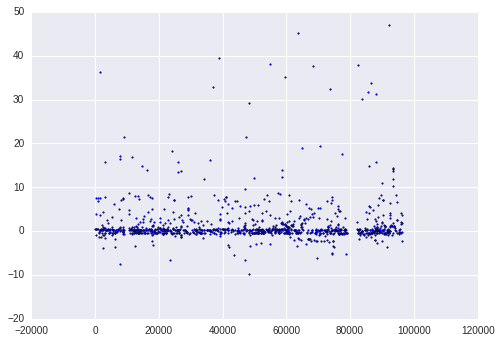

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
vals = sorted(deviances.iteritems(), key=lambda x: x[0])
positions, vals = zip(*vals)
vals = [np.nanmean(x) for x in vals]
plt.scatter(positions, vals, s=3)

In [11]:
from collections import *

deviances_by_paralog = defaultdict(lambda: defaultdict(list))

for n, df in dev_dfs.iteritems():
    for _, s in df.iterrows():
        if s.NN > 0:
            deviances_by_paralog['NN'][s['loc']].append(s['deviance'])
        if s.NAB > 0:
            deviances_by_paralog['NAB'][s['loc']].append(s['deviance'])
        if s.NC > 0:
            deviances_by_paralog['NC'][s['loc']].append(s['deviance'])
        if s.ND > 0:
            deviances_by_paralog['ND'][s['loc']].append(s['deviance'])

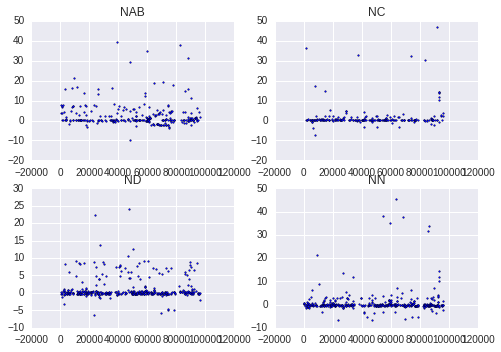

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2)
for ax, p in zip(axes.flat, deviances_by_paralog):
    vals = sorted(deviances_by_paralog[p].iteritems(), key=lambda x: x[0])
    positions, vals = zip(*vals)
    vals = [np.nanmean(x) for x in vals]
    ax.scatter(positions, vals, s=3)
    ax.set_title(p)

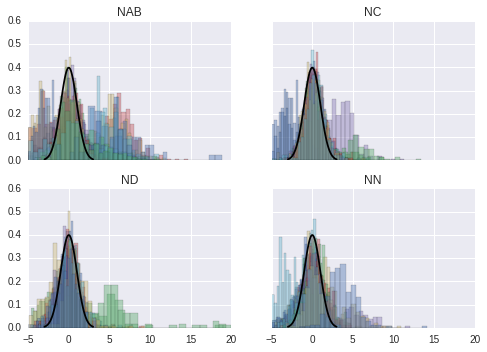

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
import matplotlib.mlab as mlab
import math
mu = 0
variance = 1
sigma = math.sqrt(variance)
norm_x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for ax, p in zip(axes.flat, deviances_by_paralog):
    v = deviances_by_paralog[p].values()
    v = [x for x in v if len(x) > 50]
    s = random.sample(v, 20)
    for d in s:
        tmp = [value for value in d if not math.isnan(value)]
        tmp = [x for x in tmp if -5 < x <= 20]
        if len(tmp) > 20:
            g = sns.distplot(tmp, kde=False, bins=25, ax=ax, norm_hist=True)
            g.set_title(p)
    ax.plot(norm_x, mlab.normpdf(norm_x, mu, sigma), color='black')

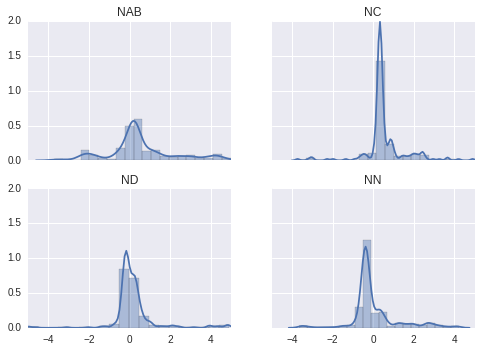

In [15]:
# distribution of average deviances for each
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for ax, p in zip(axes.flat, deviances_by_paralog):
    v = deviances_by_paralog[p].values()
    v = [np.nanmean(x) for x in v if len(x) > 25]
    v = [x for x in v if -5 < x <= 5]
    g = sns.distplot(v, bins=20, ax=ax)
    g.set_title(p)
    g.set_xlim(-5, 5)

/cluster/home/ifiddes/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


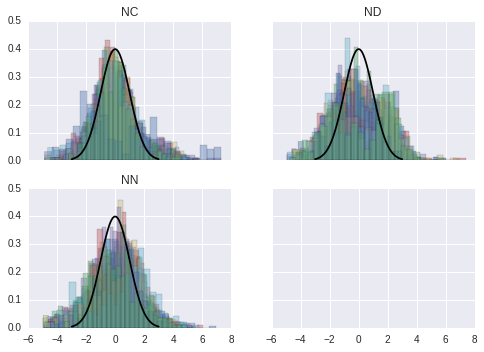

In [21]:
from collections import *
# find deviance of these with the new average ratio as p
from math import *
def new_deviance(s):
    n = s.alt_count + s.ref_count
    p = s.avg_ratio
    return ((n * p) - s.alt_count) / sqrt((n * p) * (1 - p))

bad_positions = {x for x, y in deviances.iteritems() if np.nanmean(y) > 3 or np.nanmean(y) < -3}
expected_alt = {}
seen_alts = defaultdict(list)
for df in dev_dfs.itervalues():
    for _, s in df.iterrows():
        if s.NAB > 0:
            continue
        e = 1.0 * (s.NAB + s.NC + s.ND + s.NN) / 10
        if e == 0:
            continue
        expected_alt[s['loc']] = e
        seen_alts[s['loc']].append(s.ratio)


useful_positions = set(sun_df['loc']) - bad_positions
updated_dev_dfs = {}
for n, df in dev_dfs.iteritems():
    df = df.copy()
    df = df[df['loc'].isin(useful_positions)]
    df['avg_ratio'] = [np.mean(seen_alts[p]) for p in df['loc']]
    df['adjusted_deviance'] = df.apply(new_deviance, axis=1)
    updated_dev_dfs[n] = df
    

updated_deviances_by_paralog = defaultdict(lambda: defaultdict(list))

for n, df in updated_dev_dfs.iteritems():
    for _, s in df.iterrows():
        if s.NN > 0:
            updated_deviances_by_paralog['NN'][s['loc']].append(s['adjusted_deviance'])
        if s.NC > 0:
            updated_deviances_by_paralog['NC'][s['loc']].append(s['adjusted_deviance'])
        if s.ND > 0:
            updated_deviances_by_paralog['ND'][s['loc']].append(s['adjusted_deviance'])


fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
import matplotlib.mlab as mlab
mu = 0
variance = 1
sigma = math.sqrt(variance)
norm_x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for ax, p in zip(axes.flat, updated_deviances_by_paralog):
    v = updated_deviances_by_paralog[p].values()
    v = [x for x in v if len(x) > 50]
    s = random.sample(v, 20)
    for d in s:
        tmp = [value for value in d if not math.isnan(value)]
        tmp = [x for x in tmp if -5 < x <= 20]
        if len(tmp) > 20:
            g = sns.distplot(tmp, kde=False, bins=25, ax=ax, norm_hist=True)
            g.set_title(p)
    ax.plot(norm_x, mlab.normpdf(norm_x, mu, sigma), color='black')

In [126]:
%connect_info

{
  "stdin_port": 46531, 
  "ip": "127.0.0.1", 
  "control_port": 58267, 
  "hb_port": 47489, 
  "signature_scheme": "hmac-sha256", 
  "key": "52f4f445-8f54-449c-ab03-7ab609766ed8", 
  "kernel_name": "", 
  "shell_port": 59087, 
  "transport": "tcp", 
  "iopub_port": 33274
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /cluster/home/ifiddes/.local/share/jupyter/runtime/kernel-4e695f66-664d-4240-aa96-9e4cd2dd98c5.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [22]:
print bad_positions

set([48646, 75180, 17731, 43539, 2967, 54815, 64033, 89900, 66088, 68137, 90156, 85939, 87309, 70198, 54452, 1594, 77455, 8253, 73792, 7776, 60995, 44613, 96353, 24138, 48718, 13391, 47185, 24659, 29269, 13913, 23133, 68191, 29280, 69729, 1635, 88677, 10513, 74860, 54893, 90226, 57973, 74358, 58487, 82556, 10517, 76419, 59524, 74373, 41094, 8843, 63630, 74383, 5267, 57493, 12439, 35992, 85862, 3235, 48297, 68722, 24754, 74420, 95925, 7356, 7871, 38598, 18209, 5841, 39122, 67796, 68309, 94430, 6370, 93478, 49894, 37095, 52457, 16620, 92397, 60142, 76015, 41712, 93480, 41716, 54006, 22990, 48376, 16597, 92418, 40711, 93484, 63242, 26380, 898, 92431, 29144, 49941, 43799, 48409, 91419, 90398, 92448, 25889, 64803, 10534, 24359, 39720, 46889, 93482, 25900, 93486, 76080, 20276, 78646, 53056, 86339, 76104, 41186, 14670, 67410, 23382, 83803, 17245, 17760, 63844, 88806, 74086, 26983, 46953, 88039, 878, 12655, 16345, 7957, 38774, 50409, 386, 1496, 41878, 66952, 393, 53655, 60815, 15250, 58691, 41